# Observational study

The goal of the present project is to define a valid metric to evaluate the impact of actors on movies. Specifically, distilling actors careers to a single number, the *star score*. Identifying the latter implies the need to identify truly successful actors, namely actors that had the highest positive impact on movies, in terms of revenues and ratings. Given the presence of multiple confounders, such as the affinity of actors with particulare genres or gender disparities, an observational study is carried out to limit the influence of unobserved covariates.

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline

import datetime as dt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
#importing our clean data
data = pd.read_csv('../data/data.csv', index_col = 0)
data_profit = pd.read_csv('../data/profit_data.csv', index_col = 0)
actors = pd.read_csv('../data/actorMetrics.csv', index_col = 0)
imdb = pd.read_csv('../data/imdb_budgets.csv', index_col = 0)
ss = pd.read_csv('obs.csv', index_col = 0)

In [6]:
actors['gender'] = ss['gender']
actors['birthdate'] = data['Actor_date_of_birth']
actors['birthdate'] = pd.to_datetime(actors['birthdate']).dt.year
actors['log_revenue'] = actors['revenue_avg'].apply('log')

In [7]:
actors.head(3)

,actor,revenue_avg,grade_avg,revenue_sum,grade_sum,appearances,main_genre,2nd_genre,country1,country2,tenure,gender,birthdate,log_revenue
0,Dustin_Farnum,6.117500e+06,2.861536,6.117500e+06,2.861536,1,Black-and-white,Drama,United States of America,NaN,0.0,M,1874,15.626664
1,Elmer_Clifton,1.250000e+09,4.791714,1.250000e+09,4.791714,1,Black-and-white,Costume drama,United States of America,NaN,0.0,M,1890,20.946409
2,Robert_Harron,1.250000e+09,4.791714,1.250000e+09,4.791714,1,Black-and-white,Costume drama,United States of America,NaN,0.0,M,1893,20.946409


At first, the correlation between budgets and revenues is proved. This will allow us to use revenues as a solid metric for identifying successful actors later on.

Profits are not directly used are a metric for success because of the lack of budget data from the IMDb movie dataset. Anyway, even if direct revenues can slightly influence the outputs, they are not to be ignored, because they provide useful information on movie success and popularity.

In [8]:
#group by movie
budg = data_profit.groupby('Movie_name')['budget','Movie_box_office_revenue'].mean()

Pearson's and Spearman's correlations are used to capture the correlation between the two parameters. It is clear that the is a high linear correlation because of the results shown below.

In [9]:
stats.pearsonr(budg['budget'],budg['Movie_box_office_revenue']) #pearson correlation

PearsonRResult(statistic=0.6579146048455062, pvalue=0.0)

In [10]:
stats.spearmanr(budg['budget'],budg['Movie_box_office_revenue']) #spearman correlation

SpearmanrResult(correlation=0.6470644194502557, pvalue=0.0)

In [11]:
#linear correlation plot (e.g., pearson)
#sns.lmplot('budget','Movie_box_office_revenue', data=budg)

The treatment and control group of the observational study will be identified by the number of times actors starred in movies. The assumption is that successful actors keep acting, while the career of less-successfull ones ends early. This hypothesis is supported by the rich-get-richer mechanism, for which successful actors keep starring with other successful actors, making them even more successful and naturally generating a power law in the appearances distribution.

Just as normal distributions arise from many independent random decisions averaging out, we power laws arise from the feedback introduced by correlated decisions across a population.

Source:
Networks, Crowds, and Markets: Reasoning about a Highly Connected World.
By David Easley and Jon Kleinberg. Cambridge University Press, 2010.
http://www.cs.cornell.edu/home/kleinber/networks-book/

Thedistribution of the number of appearances is shown below. The distribution is a power law because it is represented by a straight line in bi-logarithmic axes (it is linear in the log domain).

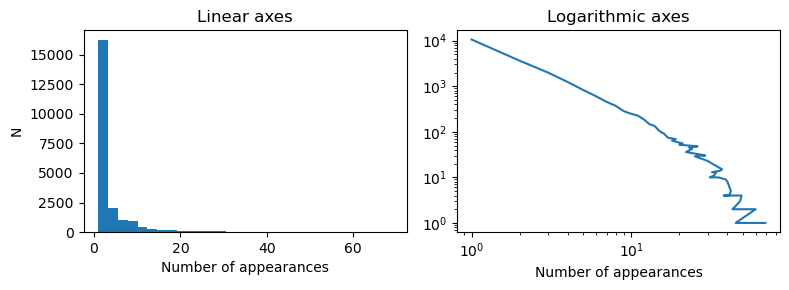

In [26]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

#group by number of appearances and sort
act = actors.groupby('appearances')['appearances'].count().sort_values(ascending=False)

sbplt = ax[0]
sbplt.hist(actors.appearances, bins=30)
sbplt.set_title('Linear axes')
sbplt.set_xlabel('Number of appearances')
sbplt.set_ylabel('N')

sbplt = ax[1]
sbplt.loglog(act.index,act.values)
sbplt.set_title('Logarithmic axes')
sbplt.set_xlabel('Number of appearances')
    
fig.tight_layout()
plt.savefig('../figures/power_law.png', bbox_inches='tight')
plt.show()

The appearances distribution split by gender shows differences between actors and actresses career. The trends are similar (power-law distributions), but the differences are evident. This is a possible confounder to be tackled when conducting the observational study.

In [29]:
#split into male/female actors
dt1 = actors[actors['gender'] == 'M']
dt2 = actors[actors['gender'] == 'F']

#group by number of appearances and sort
act1 = dt1.groupby('appearances')['appearances'].count().sort_values(ascending=False)
act2 = dt2.groupby('appearances')['appearances'].count().sort_values(ascending=False)

#compute cdf for revenue distribution by gender
rev_ordered = dt1.revenue_avg.sort_values() #sort dataset in ascending order
rev_ordered2 = dt2.revenue_avg.sort_values() #sort dataset in ascending order
tot = dt1.revenue_avg.sum() #compute total sum of revenues
tot2 = dt2.revenue_avg.sum() #compute total sum of revenues
pdf = rev_ordered.apply(lambda x: x/tot) #compute pdf
pdf2 = rev_ordered2.apply(lambda x: x/tot2) #compute pdf
cdf = np.cumsum(pdf) #compute cdf
cdf2 = np.cumsum(pdf2) #compute cdf

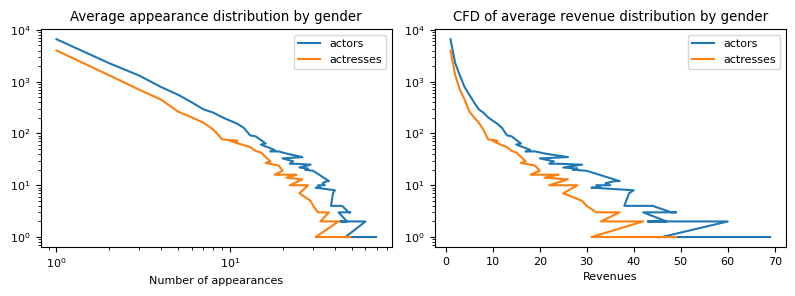

In [113]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

sbplt = ax[0]
sbplt.loglog(act1.index,act1.values, label='actors')
sbplt.loglog(act2.index,act2.values, label='actresses')
sbplt.set_title('Average appearance distribution by gender')
sbplt.set_xlabel('Number of appearances')
sbplt.legend()

sbplt = ax[1]
sbplt.semilogy(act1.index,act1.values, label='actors')
sbplt.semilogy(act2.index,act2.values, label='actresses')
sbplt.set_title('CFD of average revenue distribution by gender')
sbplt.set_xlabel('Revenues')
sbplt.legend()

fig.tight_layout()
plt.savefig('../figures/pow_gender.png', bbox_inches='tight')
plt.show()

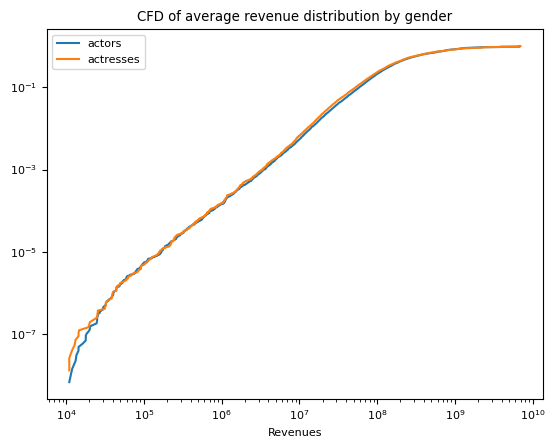

In [112]:
plt.loglog(rev_ordered,cdf,label='actors')
plt.loglog(rev_ordered2,cdf2,label='actresses')
plt.title('CFD of average revenue distribution by gender')
plt.xlabel('Revenues')
plt.legend()
plt.show()

An Z-test is also performed to verify if the difference is statistically significant. For both appearances and revenues distributions the p-values of the indepent tests are lower than the imposed threshold (0.05), therefore the null hypothesis that the averages are equal is rejected.

In [105]:
#appearances of actors/actresses
ztest(dt1.appearances, dt2.appearances) #independent test

(7.852293687516742, 4.0849652792158145e-15)

In [104]:
#appearances of actors/actresses
ztest(dt1.revenue_avg, dt2.revenue_avg) #independent test

(2.530042218861047, 0.011404880250428722)

In [106]:
#appearances of actors/actresses
ztest(dt1.grade_avg, dt2.grade_avg) #independent test

(3.938004177353809, 8.216216450147168e-05)

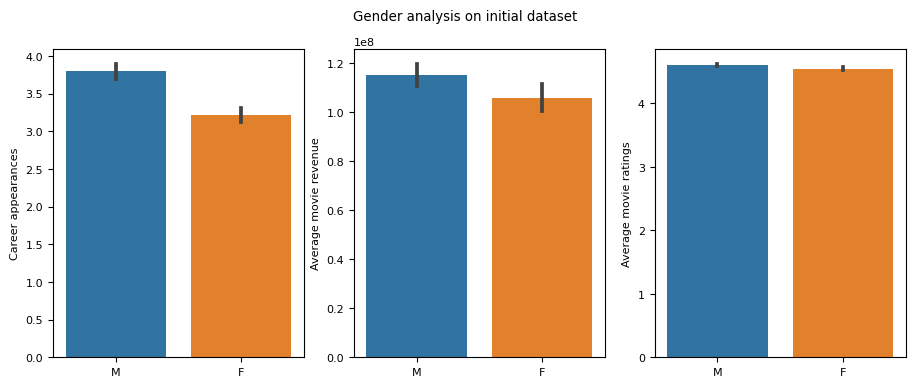

In [88]:
#bar plot with confidence intervals
import seaborn as sns

#3 subplots
fig, ax = plt.subplots(1,3, figsize=(11,4))

sbplt = ax[0]
sns.barplot(ax=ax[0], x="gender", y="appearances", data=actors)
sbplt.set_ylabel('Career appearances')
sbplt.set_xlabel('')

sbplt = ax[1]
sns.barplot(ax=ax[1], x="gender", y="revenue_avg", data=actors)
sbplt.set_ylabel('Average movie revenue')
sbplt.set_xlabel('')

sbplt = ax[2]
sns.barplot(ax=ax[2], x="gender", y="grade_avg", data=actors)
sbplt.set_ylabel('Average movie ratings')
sbplt.set_xlabel('')
    
#fig.tight_layout()
plt.rcParams.update({'font.size': 8})
plt.savefig('../figures/gender1.png', bbox_inches='tight')
fig.suptitle('Gender analysis on initial dataset')
plt.show()

Supported by rich-get-richer mechanism assumption, the treatment group will be the group with the higher number of appearances. The splitting of the dataset will be carried out based on the median of the distribution, more representative than the mean when considering skewed distributions.

Of course, younger actors may have lower number of appearances only because they are at the beginning of their career. This possible confounder must be considered in the study and the birthdate of the actors is taken into account in the propensity score matching.

In [79]:
#median
print('The median of the distribution is ' + str(np.median(actors.appearances)))
print('The mean of the distribution is ' + str(np.mean(actors.appearances)))

The median of the distribution is 2.0
The mean of the distribution is 3.588943623426382


In [80]:
#split into treatment and control groups
actors['treatment'] = (actors['appearances'] > 2).astype(int)

A first linear regression is performed on the dataset to investigate the correlation between the parameters of interest (revenues, ratings, appearances) BEFORE taking into account the matching based on propensity scores. These values could be interesting for the future comparison.

As shown from the summary of the regression, there is a positive correlation between average revenues and appearances in actors careers and negative correlation between ratings and appearances. Both correlations are statistically significant (p-value lower than 0.05).

In [144]:
#standardization of predictors
Xt = actors[{'treatment','log_revenue','ratings'}]
Xt['log_revenue'] = (Xt['log_revenue'] - Xt['log_revenue'].mean())/Xt['log_revenue'].std()
Xt['ratings'] = (Xt['ratings'] - Xt['ratings'].mean())/Xt['ratings'].std()

In [145]:
mod = smf.ols(formula='treatment ~ log_revenue + ratings',
              data=Xt)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              treatment   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     1069.
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:31:59   Log-Likelihood:                -13868.
No. Observations:               21924   AIC:                         2.774e+04
Df Residuals:                   21921   BIC:                         2.777e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3507      0.003    113.985      

To limit the effect of confounders, the individuals of the groups will be matched on propensity score, namely the probability of being in the treatment group based on observed covariates.

To extract the propensity scores, a logistic regression is trained and applied on the same dataset, this will output the needed probabilities.

In is worth mentioning that the revenues and ratings are characteristics that define the success of the movie and that will set the basis for the definition of the *star score*. Therefore, they are not included in the matching features, otherwise they would bias the process of identification of successful actors.

In [81]:
X = actors[{'main_genre','2nd_genre','gender','birthdate'}]
#X['birthdate'] = (X['birthdate'] - X['birthdate'].mean())/X['birthdate'].std()

In [82]:
X = pd.get_dummies(X,columns=['main_genre','2nd_genre','gender'])
y = actors['treatment']

In [83]:
X.head(3)

,birthdate,main_genre_Absurdism,main_genre_Action,main_genre_Action Comedy,main_genre_Action Thrillers,main_genre_Action/Adventure,main_genre_Addiction Drama,main_genre_Adult,main_genre_Adventure,main_genre_Adventure Comedy,...,2nd_genre_Suspense,2nd_genre_Teen,2nd_genre_Thriller,2nd_genre_Time travel,2nd_genre_War film,2nd_genre_Western,2nd_genre_Workplace Comedy,2nd_genre_World cinema,gender_F,gender_M
0,1874,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1890,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1893,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [84]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(solver='lbfgs', max_iter=100000)
logistic.fit(X,y)

LogisticRegression(max_iter=100000)

In [85]:
actors['propensity_score'] = [i[0] for i in list(logistic.predict_proba(X))]

To further balance the two sub-groups of actors, the process will only match actors of the same gender. Indeed, as proved before, gender gives a bias for linking the actors to movie success.

Given the extremely large size of the dataset and the matching exponential time needed to minimize the similarity difference between all the possible combinations, the matching is carried out on randomly chosen subsets of the balanced dataset. The statistical significance of the correlation will depend on the resulting p-value, corrected with the Bonferroni correction.

In [86]:
#function to compute similarity (difference between propensity scores to be minimized in the matching)
def get_similarity(prop1,prop2):
    return 1-abs(prop1-prop2)

In [87]:
import networkx as nx

In [195]:
actors_prop = actors.sort_values(by=['propensity_score'],ascending=False).reset_index()

In [104]:
coefficients = []
for i in range(20):
    ran = actors.sample(frac=.01)

    # Create an empty undirected graph
    G = nx.Graph()

    #define treatment and control groups
    treat = ran[ran['appearances'] > 2]
    contr = ran[ran['appearances'] <= 2]

# Loop through all the pairs of instances
    for i, j in contr.iterrows():
        for k, l in treat.iterrows():
            if j['gender'] == l['gender']:
                # Calculate the similarity 
                similarity = get_similarity(j['propensity_score'],
                                            l['propensity_score'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(i, k, similarity)])
                
                # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)] #create list with all indexes of people paired

    balanced_df = actors.loc[matched] #extract only rows with paired subjects
    
    X1 = balanced_df[{'treatment','revenues','ratings'}]
    X1['revenues'] = X1['revenues'].apply('log')
    #X1['ratings'] = X1['ratings'].apply('log')
    X1['revenues'] = (X1['revenues'] - X1['revenues'].mean())/X1['revenues'].std()
    X1['ratings'] = (X1['ratings'] - X1['ratings'].mean())/X1['ratings'].std()
    
    import statsmodels.formula.api as smf
    
    mod = smf.ols(formula='treatment ~ revenues + ratings',
              data=X1)
    res = mod.fit()
    coeff = res.params.values
    p_values = res.pvalues
    
    coefficients.append({"Int": coeff[0], 'p_int': p_values[0], "C1": coeff[1], 'p1': p_values[1], "C2": coeff[2], 'p2': p_values[2]})

The results of the linear regression on the balanced datasets are shown below. In this case, given the number of randomly chosen samples (10), the Bonferroni correction would be given by:

$\alpha = \frac{\alpha_i}{n} = \frac{0.05}{10} = 0.005$

where $\alpha$ is the overall alpha level, $\alpha_i$ are the alpha levels for each hypothesis and $n$ is the number of hypothesis.

From the results, it it possible to observe that there is always a positive correlation with the revenues and a negative correlation with the ratings. However, only the revenues show statistical significance, given that the p-values of all the conducted tests are larger than the imposed threshold.

This results can be compared to the initial results of the regression done before the propensity score matching. The interesting variation is the non-statistical significance of the negative correlation between ratings and actors' appearances. Based on common sense, we can indeed conclude that actors that enter the rich-get-richer mecahnism loop and keep starring in movies increase the ratings of the movies they star in. The negative trend here shown is due to chance, and that is proved by the high p-value.

In [106]:
coef = pd.DataFrame(coefficients)

In [107]:
coef

,Int,p_int,C1,p1,C2,p2
0,0.5,1.063703e-25,0.063970,1.346034e-01,0.048032,0.260511
1,0.5,1.039421e-31,0.180170,4.895871e-06,-0.082323,0.032721
2,0.5,2.695705e-26,0.171122,4.648442e-04,-0.057159,0.233943
3,0.5,3.937830e-24,0.182169,3.566695e-05,-0.011992,0.778743
4,0.5,4.826215e-23,0.149314,3.209792e-03,-0.066981,0.180543
5,0.5,3.802448e-25,0.170697,2.091687e-04,-0.061993,0.169233
6,0.5,2.260106e-26,0.172853,1.233168e-04,-0.025241,0.565733
7,0.5,3.671886e-32,0.167653,6.267266e-05,-0.052264,0.203379
8,0.5,5.732719e-27,0.170048,1.047772e-04,0.005288,0.901572
9,0.5,2.611509e-29,0.221533,5.547944e-08,-0.136022,0.000598


In [110]:
#coefficient of correlation between appearances and log of average revenues
print(coef.C1.mean())

0.1700006309755379


In [110]:
#imdb[imdb.primaryTitle.apply(lambda x: x.endswith('2'))]

The *star score* can eventually be defined based on the above analysis.

$star\ score = \left(A + 0.17\ln{(\bar{R} \cdot)}\right)^{log(\bar{G})}$

where $A$ is the number of appearances in the actor's career and $\bar{G}$, $\bar{R}$ are the averages of the revenues and ratings caused to the movies he starred in. In this case the average is appropriate because the distribution of such parameters in actors careers is not a power law.

The coefficient 0.2 comes from linear correlation coefficient between the log of the revenues and the appearances in the previously conducted regression. Indeed, the values of the coefficients oscillate in the neighborhood of 0.17. The ratings are not linearly correlated with the appearances, but still must play a role in defining the actor's impact on the movie; the higher the career average ratings, the higher the impact. In this case, the average ratings are logged, namely there is exponent is equal to 1 when the rating is maximum (10), otherwise the star score is reduced because the log of a number between 

We believe this metric includes of the parameters of interest that relate an actor to the success of the movie. 

In [111]:
actors['log_revenue'] = actors['revenues'].apply('log')

In [218]:
#add star scores
actors['ss'] = (actors['appearances'] + 0.17*actors['log_revenue'])**np.log10(actors['ratings'])

In [125]:
actors.head(3)

,actor,revenues,movie_years,ratings,cumulative_revenue,cumulative_ratings,star_score,epfl_score,genres,genre_count,main_genre,2nd_genre,appearances,gender,birthdate,treatment,propensity_score,log_revenue,ss
0,Dustin_Farnum,6.117500e+06,[1914.],2.861536,[6117500.],[2.86153647],[16.67802278],[2.69731427],"[Black-and-white, Drama, Indie, Silent film, W...","[1, 1, 1, 1, 1]",Black-and-white,Drama,1.0,M,1874,0,0.842613,15.626664,1.807578
1,Elmer_Clifton,1.250000e+09,[1915.],4.791714,[1.25e+09],[4.79171404],[22.51329757],[4.21711313],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",Black-and-white,Costume drama,1.0,M,1890,0,0.970733,20.946409,2.808518
2,Robert_Harron,1.250000e+09,[1915.],4.791714,[1.25e+09],[4.79171404],[22.51329757],[4.21711313],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",Black-and-white,Costume drama,1.0,M,1893,0,0.970928,20.946409,2.808518


In [216]:
actors.sort_values('ss', inplace=True, ascending=False)

The distribution of the star scores in the dataset is shown below. As expected, the distribution is still skewed, because of the previously explained rich-get-richer mecahnism. However, the distribution is not a power law anymore, given that it is not a straight line in the logarithmic domain. This is interesting, because 

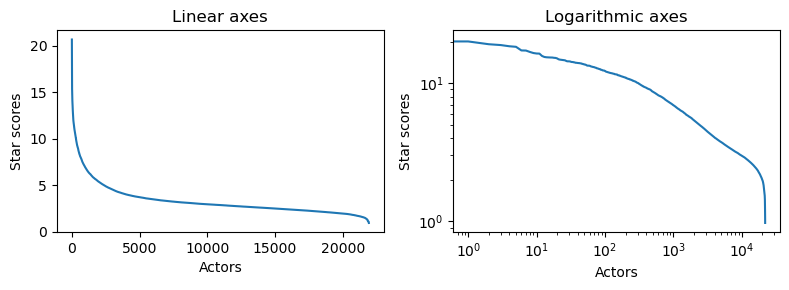

In [150]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

sbplt = ax[0]
sbplt.plot(np.arange(0,len(actors)),actors.ss)
sbplt.set_title('Linear axes')
sbplt.set_ylabel('Star scores')
sbplt.set_xlabel('Actors')

sbplt = ax[1]
plt.loglog(np.arange(0,len(actors)),actors.ss)
sbplt.set_title('Logarithmic axes')
sbplt.set_ylabel('Star scores')
sbplt.set_xlabel('Actors')

fig.tight_layout()
plt.show()

In [158]:
ss_m = actors[actors['gender'] == 'M']
ss_f = actors[actors['gender'] == 'F']

In [173]:
len(ss_f)/len(actors)

0.3602444809341361

(array([1.882e+03, 4.385e+03, 9.410e+02, 3.250e+02, 1.840e+02, 9.200e+01,
        4.600e+01, 2.700e+01, 1.200e+01, 4.000e+00]),
 array([ 0.97254864,  2.33822886,  3.70390909,  5.06958932,  6.43526954,
         7.80094977,  9.16662999, 10.53231022, 11.89799045, 13.26367067,
        14.6293509 ]),
 <BarContainer object of 10 artists>)

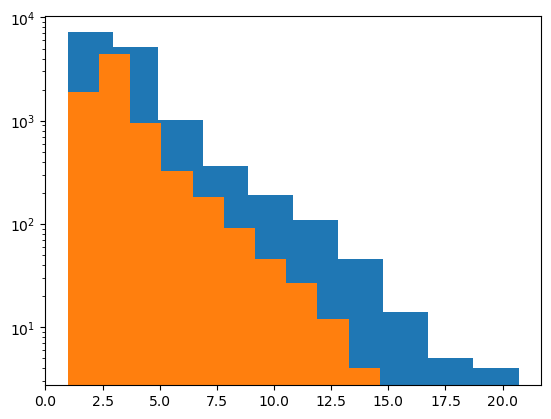

In [162]:
plt.hist(ss_m.ss,log=True)
plt.hist(ss_f.ss,log=True)

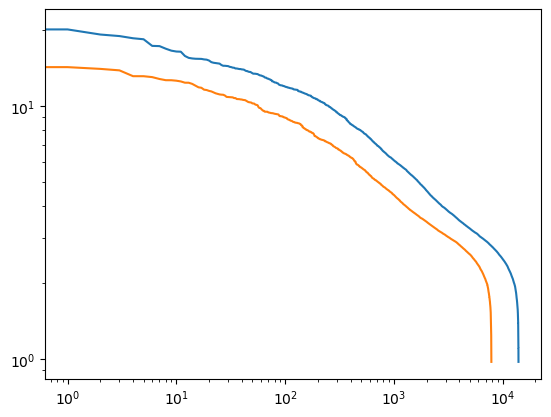

In [171]:
plt.loglog(np.arange(0,len(ss_m)),ss_m.ss)
plt.loglog(np.arange(0,len(ss_f)),ss_f.ss)
plt.show()